<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разбиение-на-выборки" data-toc-modified-id="Разбиение-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разбиение на выборки</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LGBM-регрессор" data-toc-modified-id="LGBM-регрессор-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>LGBM регрессор</a></span></li><li><span><a href="#CatBoost-регрессор" data-toc-modified-id="CatBoost-регрессор-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>CatBoost регрессор</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Модель случайного леса</a></span></li></ul></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Результаты-и-выводы" data-toc-modified-id="Результаты-и-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результаты и выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

В распоряжении исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Основные этапы работы:

- обзор данных
- предобработка и исследовательский анализ данных
- создание новых признаков
- подготовка выборок для обучения и тестирования
- обучение моделей
- анализ моделей и выбор подходящей
- тестирование модели

## Подготовка

In [1]:
!pip install -q lightgbm 

In [2]:
!pip install -q catboost 

In [3]:
# импорт библиотек
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
# убираем предупреждения
warnings.filterwarnings('ignore')

### Обзор данных

Загрузим данные и **посмотрим на общую информацию** о них:

In [5]:
try:
    df = pd.read_csv('dataset_taxi.csv')
    
except:
    df = pd.read_csv('/datasets/taxi.csv')

df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В столбце datetime содержится **информация о дате и времени**. Перезапишем датафрейм, **используя её как индекс**:

In [7]:
try:
    df = pd.read_csv('dataset_taxi.csv', index_col=[0], parse_dates=[0])
    
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Поскольку имеем временной ряд, **проверим его на монотонность**:

In [8]:
df.index.is_monotonic

True

**Ряд монотонно возрастает** от 1 марта 2018 до 31 августа 2018. **Пропущенных значений нет.** 

### Предобработка

Проверим данные на **наличие аномалий**: 

In [9]:
# уникальные значения 
df['num_orders'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  64,  65,  66,
        67,  68,  71,  76,  78,  80,  81,  82,  87,  90,  91,  94,  95,
        98,  99, 119], dtype=int64)

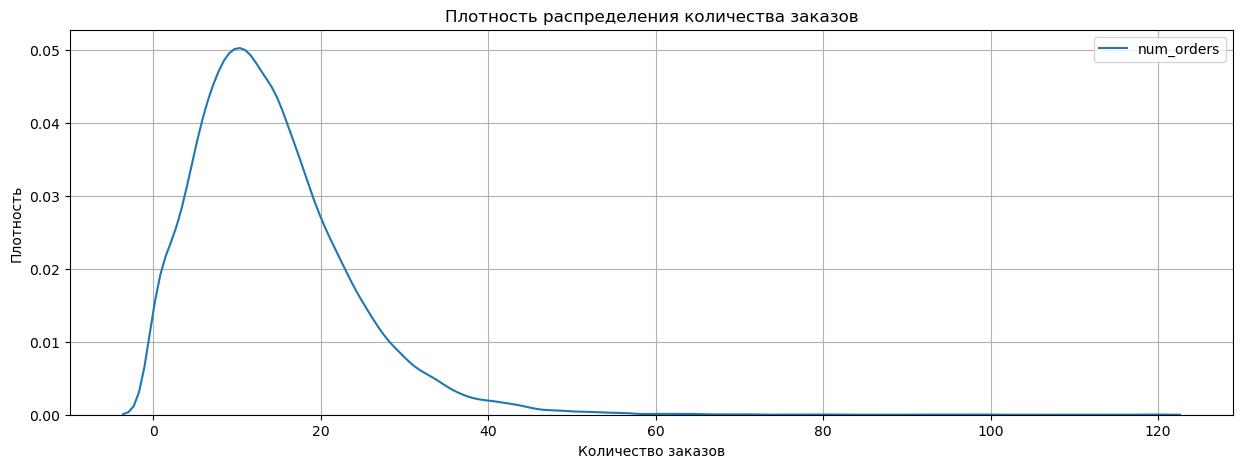

In [10]:
# график плотности распределения количества заказов
plt.figure(figsize=(15, 5))

sns.kdeplot(data=df)

plt.title(label='Плотность распределения количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Плотность')
plt.grid(True)

plt.show();

**Никаких аномалий не наблюдается.** Проведём **ресемплирование данных с шагом в 1 час**, в качестве агрегирующей функции используем сумму:

In [11]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Посмотрим как выглядит **временной ряд и скользящие средние за сутки и неделю**:

In [12]:
# создание столбцов со скользящими средними за сутки и неделю 
df['rolling_mean_day'] = df['num_orders'].shift().rolling(24).mean()
df['rolling_mean_week'] = df['num_orders'].shift().rolling(168).mean()

<Figure size 640x480 with 0 Axes>

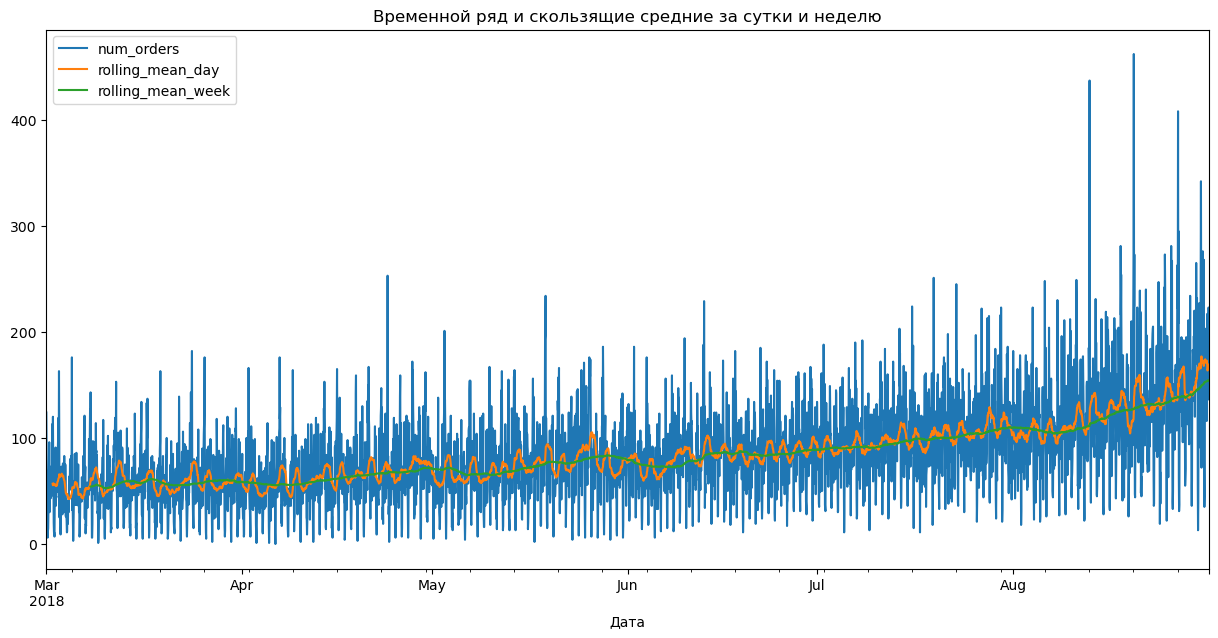

In [13]:
# построение графика
plt.figure()

df.plot(figsize=(15, 7))

plt.title('Временной ряд и скользящие средние за сутки и неделю')
plt.xlabel('Дата');

Из графика видно, что **скользящее среднее за неделю лучше отражает тренд**, в то время как скользящее среднее за день всё ещё довольно зашумлённое.

In [14]:
# удалим столбцы со скользящими средними
df = df.drop(['rolling_mean_day', 'rolling_mean_week'], axis=1)

Проанализируем **тренд** и **сезонность** для имеющегося ряда. Поскольку имеем данные с шагом в 1 час для начала **посмотрим диапазон в 2 недели**:

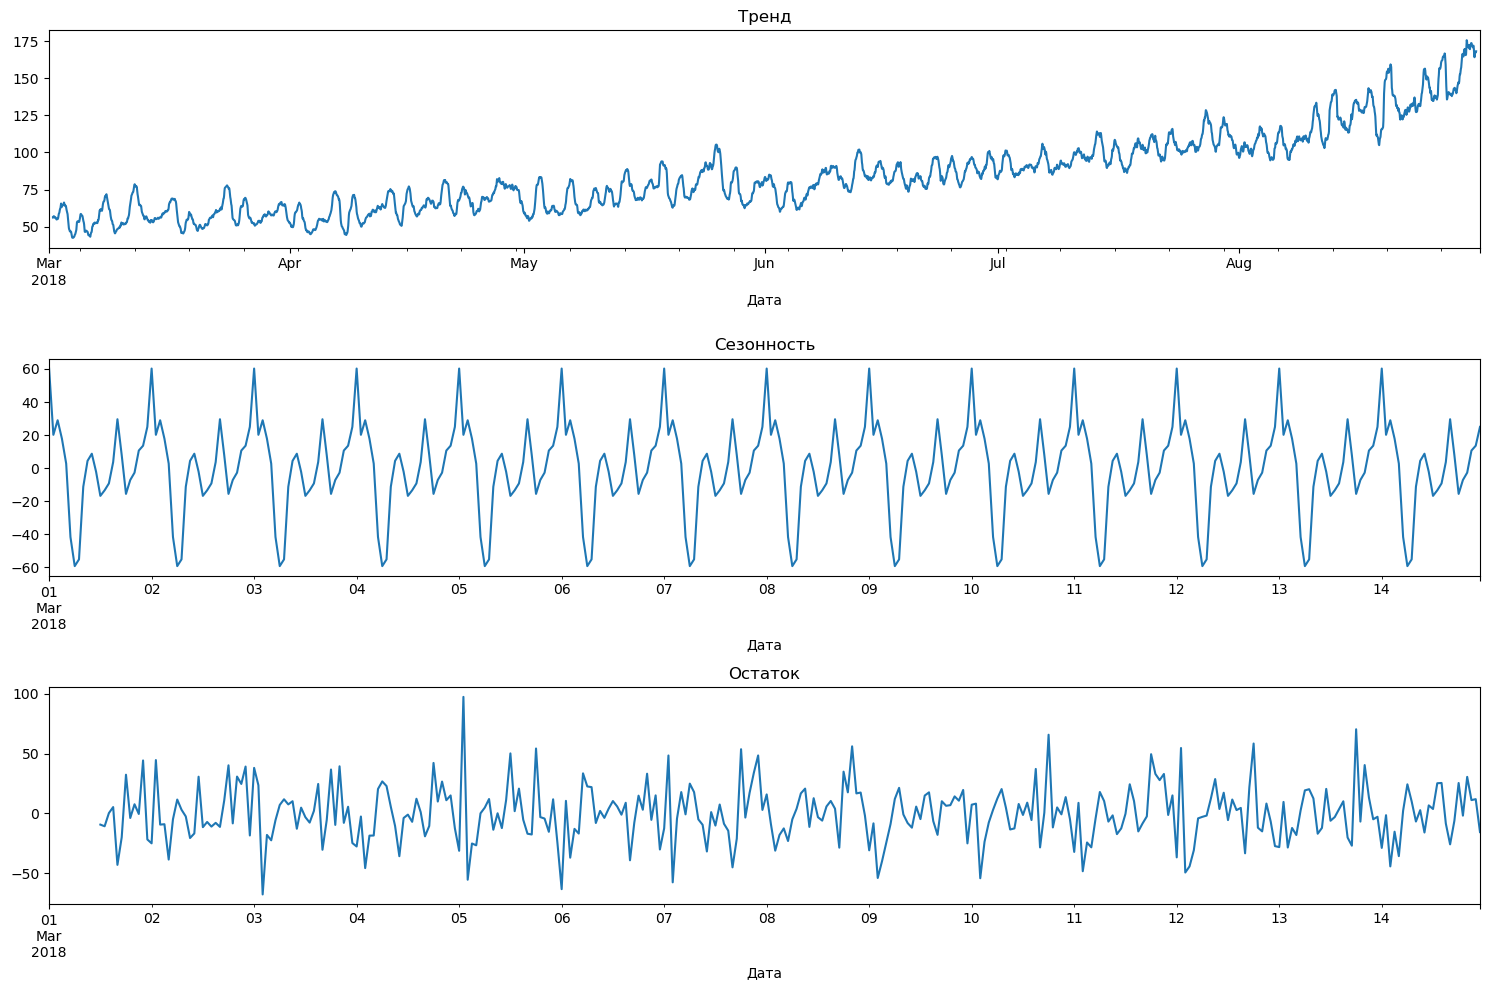

In [15]:
# декомпозиция временного ряда на составляющие 
decomposed = seasonal_decompose(df['num_orders'])

# построение графиков с трендом, сезонностью и остатком
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-14'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-14'].plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Дата')

plt.tight_layout();

**Говорить о наличии чёткой закономерности в тренде достаточно сложно, поскольку диапазон времени слишком маленький**. В то же время, по графику с сезонной составляющей можно судить о наиболее нагруженных часах в работе такси в течение дня. Так, **наибольшее число заказов приходится на время в районе полуночи. Наблюдаются также пики в утренние (7-8 ч) и вечерние (18-19) часы**, которые, во всей видимости, связаны с началом и окончанием рабочего дня.

Для определения более глобальных зависимостей, **рассмотрим данные на всём имеющемся диапазоне**, но ресемплированные **с шагом в 1 день**:

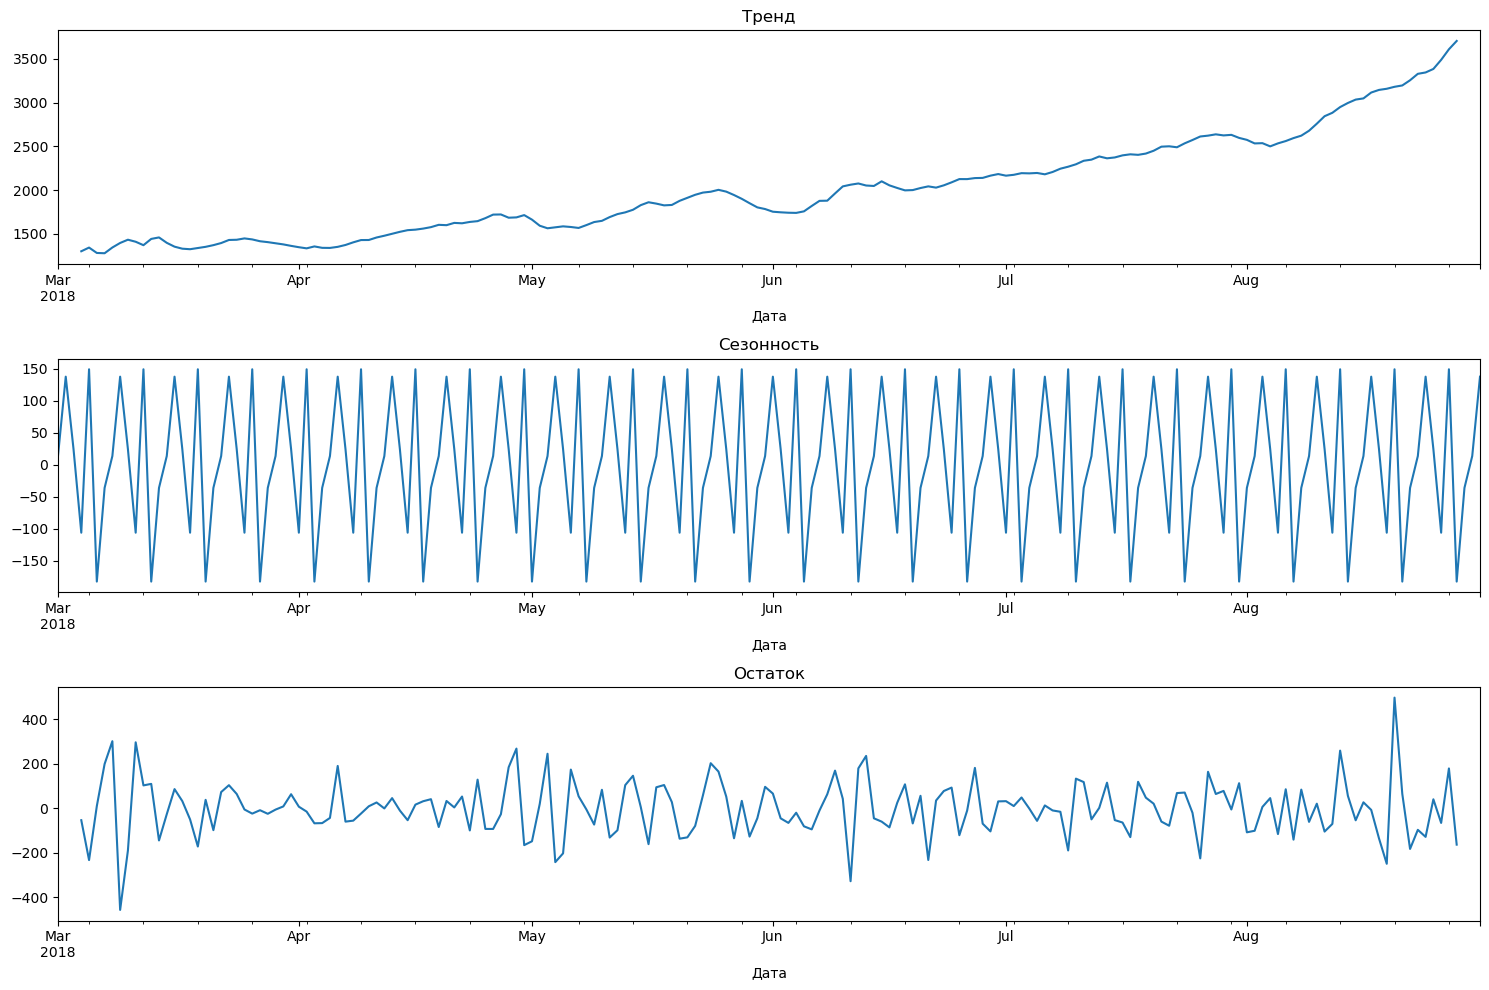

In [16]:
# декомпозиция временного ряда на составляющие 
decomposed = seasonal_decompose(df['num_orders'].resample('1D').sum())

# построение графиков с трендом, сезонностью и остатком
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Дата')

plt.tight_layout();

Здесь уже можно увидеть **тренд** - **рост числа заказов** с начала весны и до самого конца лета. Также **наблюдаются зависимости в рамках недели** - постепенный рост числа заказов в будни, резкое падение в субботу и вновь пик в воскресенье.  

## Обучение

### Создание признаков

**Число заказов в час является таргетом**. В качестве **признаков** извлечём из даты **информацию о дне недели и часе**, поскольку наблюдали недельную сезонность и сезонность в течение дня. Также рассчитаем **отстающие значения и скользящее среднее**. Создадим функцию, которая создаст признаки, а **также удалит возникающие пропуски**:   

In [17]:
def make_features(data, max_lag, mean_size):
    
    data_new = data.copy()
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
        
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(mean_size).mean()

    data_new = data_new.dropna()
    
    return data_new

**Подберём наиболее подходящее количество отстающих значений, а также размер окна для скользящего среднего**. Для тестирования используем LGBMRegressor:

In [18]:
%%time

best_rmse = 1000
best_max_lag = 0
best_mean_size = 0

for max_lag in [24, 48, 72, 96, 120, 144, 168]:
    for mean_size in [24, 48, 72, 96, 120, 144, 168]:
        
        df_new = make_features(df, max_lag, mean_size)
        f_train, f_test, t_train, t_test = train_test_split(df_new.drop(['num_orders'], axis=1), 
                                                            df_new['num_orders'],
                                                            shuffle=False, test_size=0.1)
        f_train, f_valid, t_train, t_valid = train_test_split(f_train, t_train,
                                                              shuffle=False, test_size=0.1)
        
        model = LinearRegression()
        model.fit(f_train, t_train)
        predictions = model.predict(f_valid)
        rmse = mean_squared_error(t_valid, predictions) ** 0.5
        
        if best_rmse > rmse:
            best_rmse = rmse
            best_max_lag = max_lag
            best_mean_size = mean_size

CPU times: total: 57.8 s
Wall time: 40.8 s


In [19]:
print('Лучший RMSE:', best_rmse, '/', 'Количество отстающих значений:', best_max_lag, '/',
      'Размер окна:', best_mean_size)

Лучший RMSE: 28.97626705465381 / Количество отстающих значений: 168 / Размер окна: 48


**Используем функцию создания признаков с подобранными параметрами**:

In [20]:
df_final = make_features(df, 168, 48)

### Разбиение на выборки

Создадим **обучающие и тестовые выборки с признаками и таргетом**, не перемешивая исходную выборку:

In [21]:
# деление на обучающую (90%) и тестовую (10%) выборки:
f_train, f_test, t_train, t_test = train_test_split(df_final.drop(['num_orders'], axis=1), 
                                                    df_final['num_orders'],
                                                    shuffle=False, test_size=0.1)
 
# проверка корректности разбиения
print(f_train.shape[0], '/', f_test.shape[0], '/', t_train.shape[0], '/', t_test.shape[0])
print(f_train.index[0], '/', t_train.index[-1], '/', f_test.index[0], '/', t_test.index[-1])

3823 / 425 / 3823 / 425
2018-03-08 00:00:00 / 2018-08-14 06:00:00 / 2018-08-14 07:00:00 / 2018-08-31 23:00:00


Для дальнейшего обучения создадим **кросс-валидатор для временных рядов**:

In [22]:
tscv = TimeSeriesSplit(n_splits=4)

### Обучение моделей

Нас **интересуют качество (RMSE)**. Создадим список и функцию, которые будут собирать эту информацию о выбранных моделях:

In [23]:
# списки для интересующей информации о моделях
rmse_cv_list = []

In [24]:
def model_info(model):
    
# Извлекает RMSE для лучшей подобранной модели,  
# сохраняет в список и выводит на экран. 
     
    rmse = abs(round(model.best_score_, 3))
    rmse_cv_list.append(rmse)
    
    return display(f'RMSE: {rmse}', model.best_params_)

#### LGBM регрессор

In [25]:
# создание pipeline для LGBMRegressor
pipe_lgbm = make_pipeline(LGBMRegressor(random_state=42))

# сетка параметров для GridSearchCV
param_grid_lgbm = {'lgbmregressor__n_estimators' : [100, 200, 300],
                   'lgbmregressor__max_depth' : [5, 10]}              

In [26]:
%%time

# подбор лучших гиперпараметров модели кросс-валидацией
GSCV_pipe_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=tscv, n_jobs=-1,
                              scoring='neg_root_mean_squared_error', error_score='raise')

GSCV_pipe_lgbm.fit(f_train, t_train)

CPU times: total: 2.58 s
Wall time: 23 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('lgbmregressor',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__max_depth': [5, 10],
                         'lgbmregressor__n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [27]:
# вывод информации о лучшей модели
model_info(GSCV_pipe_lgbm)

'RMSE: 23.065'

{'lgbmregressor__max_depth': 5, 'lgbmregressor__n_estimators': 100}

#### CatBoost регрессор

In [28]:
# создание pipeline для CatBoostRegressor
pipe_cat = make_pipeline(CatBoostRegressor(random_state=42))

# сетка параметров для GridSearchCV
param_grid_cat = {'catboostregressor__max_depth' : [5, 10],
                  'catboostregressor__n_estimators' : [600, 700, 800]}

In [29]:
%%time

# подбор лучших гиперпараметров модели кросс-валидацией
GSCV_pipe_cat = GridSearchCV(pipe_cat, param_grid_cat, cv=tscv, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', error_score='raise')

GSCV_pipe_cat.fit(f_train, t_train)

Learning rate set to 0.060672
0:	learn: 37.5412910	total: 186ms	remaining: 2m 28s
1:	learn: 36.3522020	total: 210ms	remaining: 1m 23s
2:	learn: 35.2420755	total: 229ms	remaining: 1m
3:	learn: 34.2508418	total: 246ms	remaining: 48.9s
4:	learn: 33.3466406	total: 261ms	remaining: 41.4s
5:	learn: 32.4673092	total: 273ms	remaining: 36.2s
6:	learn: 31.5860578	total: 285ms	remaining: 32.3s
7:	learn: 30.8149160	total: 299ms	remaining: 29.6s
8:	learn: 30.1045856	total: 311ms	remaining: 27.3s
9:	learn: 29.4402953	total: 323ms	remaining: 25.5s
10:	learn: 28.8265939	total: 334ms	remaining: 24s
11:	learn: 28.2761489	total: 346ms	remaining: 22.7s
12:	learn: 27.6932181	total: 358ms	remaining: 21.7s
13:	learn: 27.2219598	total: 371ms	remaining: 20.8s
14:	learn: 26.7457392	total: 385ms	remaining: 20.1s
15:	learn: 26.3282172	total: 398ms	remaining: 19.5s
16:	learn: 25.9275124	total: 412ms	remaining: 19s
17:	learn: 25.5503753	total: 428ms	remaining: 18.6s
18:	learn: 25.1976637	total: 441ms	remaining: 18.

162:	learn: 18.6677247	total: 2.52s	remaining: 9.84s
163:	learn: 18.6470233	total: 2.53s	remaining: 9.81s
164:	learn: 18.6189730	total: 2.54s	remaining: 9.79s
165:	learn: 18.5968797	total: 2.56s	remaining: 9.77s
166:	learn: 18.5773147	total: 2.57s	remaining: 9.75s
167:	learn: 18.5734515	total: 2.58s	remaining: 9.72s
168:	learn: 18.5564473	total: 2.6s	remaining: 9.7s
169:	learn: 18.5424399	total: 2.61s	remaining: 9.68s
170:	learn: 18.5384249	total: 2.63s	remaining: 9.67s
171:	learn: 18.5347303	total: 2.64s	remaining: 9.65s
172:	learn: 18.5182189	total: 2.66s	remaining: 9.64s
173:	learn: 18.4957470	total: 2.67s	remaining: 9.62s
174:	learn: 18.4921833	total: 2.69s	remaining: 9.6s
175:	learn: 18.4889262	total: 2.7s	remaining: 9.59s
176:	learn: 18.4857511	total: 2.72s	remaining: 9.57s
177:	learn: 18.4573412	total: 2.73s	remaining: 9.56s
178:	learn: 18.4535627	total: 2.75s	remaining: 9.54s
179:	learn: 18.4501054	total: 2.76s	remaining: 9.52s
180:	learn: 18.4470544	total: 2.78s	remaining: 9.5

328:	learn: 16.0514523	total: 5.04s	remaining: 7.21s
329:	learn: 16.0425331	total: 5.06s	remaining: 7.2s
330:	learn: 16.0283361	total: 5.08s	remaining: 7.19s
331:	learn: 16.0053008	total: 5.09s	remaining: 7.18s
332:	learn: 16.0009957	total: 5.11s	remaining: 7.17s
333:	learn: 15.9902173	total: 5.13s	remaining: 7.15s
334:	learn: 15.9785448	total: 5.14s	remaining: 7.14s
335:	learn: 15.9749453	total: 5.16s	remaining: 7.13s
336:	learn: 15.9664564	total: 5.18s	remaining: 7.11s
337:	learn: 15.9464908	total: 5.19s	remaining: 7.1s
338:	learn: 15.9449200	total: 5.21s	remaining: 7.09s
339:	learn: 15.9284067	total: 5.23s	remaining: 7.07s
340:	learn: 15.9096556	total: 5.25s	remaining: 7.06s
341:	learn: 15.8889819	total: 5.26s	remaining: 7.05s
342:	learn: 15.8719495	total: 5.28s	remaining: 7.04s
343:	learn: 15.8659587	total: 5.3s	remaining: 7.03s
344:	learn: 15.8535842	total: 5.32s	remaining: 7.01s
345:	learn: 15.8287103	total: 5.33s	remaining: 7s
346:	learn: 15.8094344	total: 5.35s	remaining: 6.99s

485:	learn: 14.2417363	total: 8s	remaining: 5.17s
486:	learn: 14.2318352	total: 8.02s	remaining: 5.15s
487:	learn: 14.2155845	total: 8.03s	remaining: 5.13s
488:	learn: 14.2068341	total: 8.05s	remaining: 5.12s
489:	learn: 14.1945914	total: 8.06s	remaining: 5.1s
490:	learn: 14.1848911	total: 8.08s	remaining: 5.08s
491:	learn: 14.1782777	total: 8.09s	remaining: 5.07s
492:	learn: 14.1689435	total: 8.11s	remaining: 5.05s
493:	learn: 14.1591461	total: 8.13s	remaining: 5.03s
494:	learn: 14.1507042	total: 8.14s	remaining: 5.01s
495:	learn: 14.1449431	total: 8.15s	remaining: 5s
496:	learn: 14.1394405	total: 8.17s	remaining: 4.98s
497:	learn: 14.1305221	total: 8.18s	remaining: 4.96s
498:	learn: 14.1171603	total: 8.2s	remaining: 4.95s
499:	learn: 14.1054602	total: 8.21s	remaining: 4.93s
500:	learn: 14.0962644	total: 8.23s	remaining: 4.91s
501:	learn: 14.0766765	total: 8.25s	remaining: 4.89s
502:	learn: 14.0744229	total: 8.26s	remaining: 4.88s
503:	learn: 14.0630416	total: 8.28s	remaining: 4.86s
5

647:	learn: 12.6031678	total: 11s	remaining: 2.57s
648:	learn: 12.5835413	total: 11s	remaining: 2.56s
649:	learn: 12.5768579	total: 11s	remaining: 2.54s
650:	learn: 12.5652855	total: 11s	remaining: 2.52s
651:	learn: 12.5550746	total: 11s	remaining: 2.5s
652:	learn: 12.5491831	total: 11.1s	remaining: 2.49s
653:	learn: 12.5337484	total: 11.1s	remaining: 2.47s
654:	learn: 12.5274857	total: 11.1s	remaining: 2.46s
655:	learn: 12.5117517	total: 11.1s	remaining: 2.44s
656:	learn: 12.5107864	total: 11.1s	remaining: 2.42s
657:	learn: 12.5018102	total: 11.1s	remaining: 2.4s
658:	learn: 12.4915402	total: 11.2s	remaining: 2.39s
659:	learn: 12.4783241	total: 11.2s	remaining: 2.37s
660:	learn: 12.4658715	total: 11.2s	remaining: 2.36s
661:	learn: 12.4580066	total: 11.2s	remaining: 2.34s
662:	learn: 12.4518453	total: 11.2s	remaining: 2.32s
663:	learn: 12.4409442	total: 11.3s	remaining: 2.31s
664:	learn: 12.4394613	total: 11.3s	remaining: 2.29s
665:	learn: 12.4280711	total: 11.3s	remaining: 2.27s
666:	

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x000001860A624310>)]),
             n_jobs=-1,
             param_grid={'catboostregressor__max_depth': [5, 10],
                         'catboostregressor__n_estimators': [600, 700, 800]},
             scoring='neg_root_mean_squared_error')

In [30]:
# вывод информации о лучшей модели
model_info(GSCV_pipe_cat)

'RMSE: 22.794'

{'catboostregressor__max_depth': 5, 'catboostregressor__n_estimators': 800}

#### Модель случайного леса

In [31]:
# создание pipeline для RandomForestRegressor
pipe_forest = make_pipeline(RandomForestRegressor(random_state=42))

# сетка параметров для GridSearchCV
param_grid = {'randomforestregressor__max_depth' : [5, 10],
              'randomforestregressor__n_estimators' : [400, 500, 600]}

In [32]:
%%time

# подбор лучших гиперпараметров модели кросс-валидацией
GSCV_pipe_forest = GridSearchCV(pipe_forest, param_grid, cv=tscv, n_jobs=-1,
                                scoring='neg_root_mean_squared_error')

GSCV_pipe_forest.fit(f_train, t_train)

CPU times: total: 3min 6s
Wall time: 11min 35s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [5, 10],
                         'randomforestregressor__n_estimators': [400, 500,
                                                                 600]},
             scoring='neg_root_mean_squared_error')

In [33]:
# вывод информации о лучшей модели
model_info(GSCV_pipe_forest)

'RMSE: 23.073'

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 500}

### Сравнение моделей

**Для наглядности** сравнения различных моделей, **соберём всё в датафрейм**:

In [34]:
# список с названиями моделей
model_list = ['GSCV_pipe_lgbm', 'GSCV_pipe_cat', 'GSCV_pipe_forest']

# создание пустого словаря
model_cv_metrics = {} 

# добавление собранных списков в словарь
model_cv_metrics['model'] = model_list
model_cv_metrics['RMSE'] = rmse_cv_list

# преобразование словаря в датафрейм
model_cv_metrics = pd.DataFrame(data=model_cv_metrics) 
model_cv_metrics.style.background_gradient('coolwarm', axis=0)

,model,RMSE
0,GSCV_pipe_lgbm,23.065000
1,GSCV_pipe_cat,22.794000
2,GSCV_pipe_forest,23.073000


**Лучшее значения RMSE по кросс-валидации демонстрирует CatBoostRegressor**, именно эту модель и будем использовать для тестирвания.

## Тестирование

**Проверим** выбранную модель **GSCV_pipe_cat на тестовых данных**:

In [35]:
# предсказание на тестовой выборке
prediction = GSCV_pipe_cat.predict(f_test)

# RMSE на тестовой выборке
rmse = mean_squared_error(t_test, prediction) ** 0.5
round(rmse)

37

**Значение метрики на тестовой выборке заметно упало**, хотя и вписывается в заданные рамки.

## Результаты и выводы

Обзор данных **не выявил каких-либо аномалий и пропусков**. Поскольку данные представляли собой временной ряд (с 1 марта 2018 по 31 августа 2018), **в качестве индексов использовали информацию о дате и времени**. Также выполнили **ресемплирование данных с шагом в 1 час**.

Исследовательский анализ показал, что **наиболее нагруженным в работе такси** в течение дня являются **время в районе полуночи, а также утренние (7-8 ч) и вечерние (18-19) часы**, которые, вероятно, связаны с началом и окончанием рабочего дня. Помимо этого наблюдаются **зависимости в рамках недели - постепенный рост числа заказов в будни, резкое падение в субботу и вновь пик в воскресенье. Общий тренд - рост числа заказов на всём представленном временном промежутке**.
     
Поскольку в исходных данных представлены только информация о дате-времени и о числе заказов (таргет), **для обучения модели создали дополнительные признаки**:
   
   - категориальные: информация о дне недели и часе,
   - количественные: отстающие значения (168), скользящее среднее (по 48 ч).
   

Перед обучением данные **разбили на  обучающую и тестовую выборки в отношении 9 : 1**, выборку при этом не мешали. **Подбор параметров и обучение моделей** проводили с помощью **GridSearchCV**. Чтобы избежать утечку данных при кросс-валидации **использовали конвеерную обработку (Pipeline)**. Чтобы избежать предсказаний прошлого по будущему при кросс-валидации, **использовали кросс-валидатор для временных рядов**. Для сравнения выбрали **LGBMRegressor, CatBoostRegressor и RandomForestRegressor**, модели **сравнивали по качеству (RMSE)**.

**Все модели продемонстрировали близкие значения RMSE** - около 23 заказов с разницей менее, чем в один заказ. Дальнейшее **тестирование проводили на лучшей модели - GSCV_pipe_cat**. Значение **RMSE на тестовой выборке состаило 38 заказов**. 